In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/COMP90086_2024_Project_train\(1\).zip /content/train.zip
!cp /content/drive/My\ Drive/COMP90086_2024_Project_test.zip /content/test.zip

In [ ]:
!unzip /content/train.zip -d /content/
!unzip /content/test.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/648453.jpg  
  inflating: /content/train/648545.jpg  
  inflating: /content/train/648997.jpg  
  inflating: /content/train/649018.jpg  
  inflating: /content/train/649301.jpg  
  inflating: /content/train/649460.jpg  
  inflating: /content/train/649643.jpg  
  inflating: /content/train/649756.jpg  
  inflating: /content/train/649948.jpg  
  inflating: /content/train/64996.jpg  
  inflating: /content/train/650541.jpg  
  inflating: /content/train/650557.jpg  
  inflating: /content/train/650678.jpg  
  inflating: /content/train/6507.jpg  
  inflating: /content/train/650779.jpg  
  inflating: /content/train/651444.jpg  
  inflating: /content/train/651608.jpg  
  inflating: /content/train/651679.jpg  
  inflating: /content/train/651868.jpg  
  inflating: /content/train/651911.jpg  
  inflating: /content/train/652180.jpg  
  inflating: /content/train/652268.jpg  
  inflating: /content/train/652340.jpg  
  inflati

In [ ]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Concatenate, LayerNormalization, Layer)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Load and preprocess the data
def load_data(image_folder, metadata_path, num_samples=None):
    # Load metadata
    metadata = pd.read_csv(metadata_path)

    # If num_samples is provided, take the first 'num_samples' rows
    if num_samples:
        metadata = metadata.head(num_samples)

    return metadata

def load_and_preprocess_image(filepath):
    image = load_img(filepath)
    return image

def img_augmentation(images, transform):
    for img in images:
      augmented = transform(image=img)
      img = augmented['image']
    return images

In [ ]:
def segmentation(images):
  segmented_images = np.zeros_like(images)
  centroids = []
  for idx, img in enumerate(images):

    # # Increase contrast by scaling pixel values
    # contrasted_image = img.astype('float32')
    # alpha = 10 # Contrast control (1.0 - 3.0)
    # beta = 0    # Brightness control (0 - 100)
    # contrasted_image = cv2.convertScaleAbs(contrasted_image * alpha + beta)

    gau_kernel = cv2.getGaussianKernel(5,3)
    gau_kern2d = gau_kernel/gau_kernel.sum()
    gau_img = cv2.sepFilter2D(img, -1, gau_kernel, gau_kernel)

    img_canny = cv2.Canny(gau_img, 100, 200, apertureSize=3, L2gradient=True)
    kernel = np.ones((5, 5), np.uint8)
    img_dilated = cv2.dilate(img_canny, kernel, iterations=1)

    contours, _ = cv2.findContours(img_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)  # Fill valid contours

    segmented_img = cv2.bitwise_and(img, img, mask=mask)

    segmented_images[idx] = segmented_img

  return segmented_images

In [ ]:
# Load the data
image_folder = '/content/train'
metadata_path = 'train.csv'
metadata = load_data(image_folder, metadata_path)

metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7680 entries, 0 to 7679
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                7680 non-null   int64
 1   shapeset          7680 non-null   int64
 2   type              7680 non-null   int64
 3   total_height      7680 non-null   int64
 4   instability_type  7680 non-null   int64
 5   cam_angle         7680 non-null   int64
 6   stable_height     7680 non-null   int64
dtypes: int64(7)
memory usage: 420.1 KB


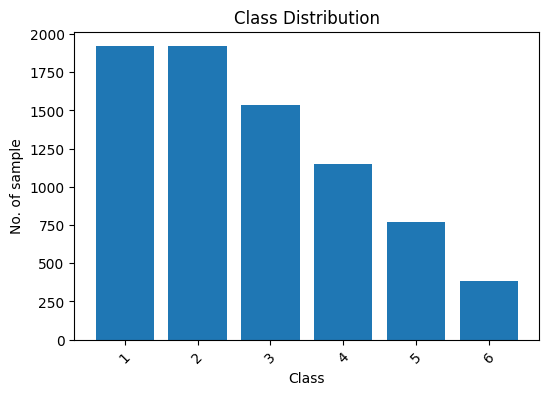

In [ ]:
class_counts = metadata['stable_height'].value_counts()

plt.figure(figsize=(6, 4))

plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('No. of sample')
plt.xticks(rotation=45)
plt.show()

In [ ]:
train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_augmentation = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_metadata, val_metadata, train_labels, val_labels = train_test_split(metadata, metadata['stable_height'], test_size=0.2, random_state=42, stratify=metadata['stable_height'])

train_images = np.array([load_and_preprocess_image(os.path.join(image_folder, str(fname)+'.jpg')) for fname in train_metadata['id']])
#train_images = img_augmentation(train_images, train_augmentation)
#train_images_segmented = segmentation(train_images)

val_images = np.array([load_and_preprocess_image(os.path.join(image_folder, str(fname)+'.jpg')) for fname in val_metadata['id']])
#val_images = img_augmentation(val_images, val_test_augmentation)
#val_images_segmented = segmentation(val_images)

array([[[ 58,  85, 114],
        [ 58,  85, 114],
        [ 58,  85, 114],
        ...,
        [ 57,  84, 111],
        [ 57,  84, 111],
        [ 57,  84, 111]],

       [[ 58,  85, 114],
        [ 58,  85, 114],
        [ 58,  85, 114],
        ...,
        [ 57,  84, 111],
        [ 57,  84, 111],
        [ 57,  84, 111]],

       [[ 58,  85, 114],
        [ 58,  85, 114],
        [ 58,  85, 114],
        ...,
        [ 57,  84, 111],
        [ 57,  84, 111],
        [ 57,  84, 111]],

       ...,

       [[188, 140, 102],
        [187, 142, 103],
        [189, 144, 105],
        ...,
        [223, 164,  96],
        [227, 164,  95],
        [229, 165,  94]],

       [[174, 131,  97],
        [173, 130,  96],
        [172, 129,  95],
        ...,
        [229, 166,  97],
        [234, 167,  97],
        [235, 168,  97]],

       [[143, 102,  70],
        [127,  86,  54],
        [102,  63,  32],
        ...,
        [235, 171, 100],
        [236, 169,  98],
        [234, 166,  93]]], dtype=uint8)
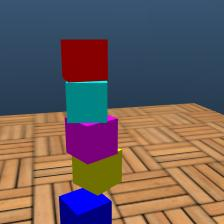

In [ ]:
train_images[0]

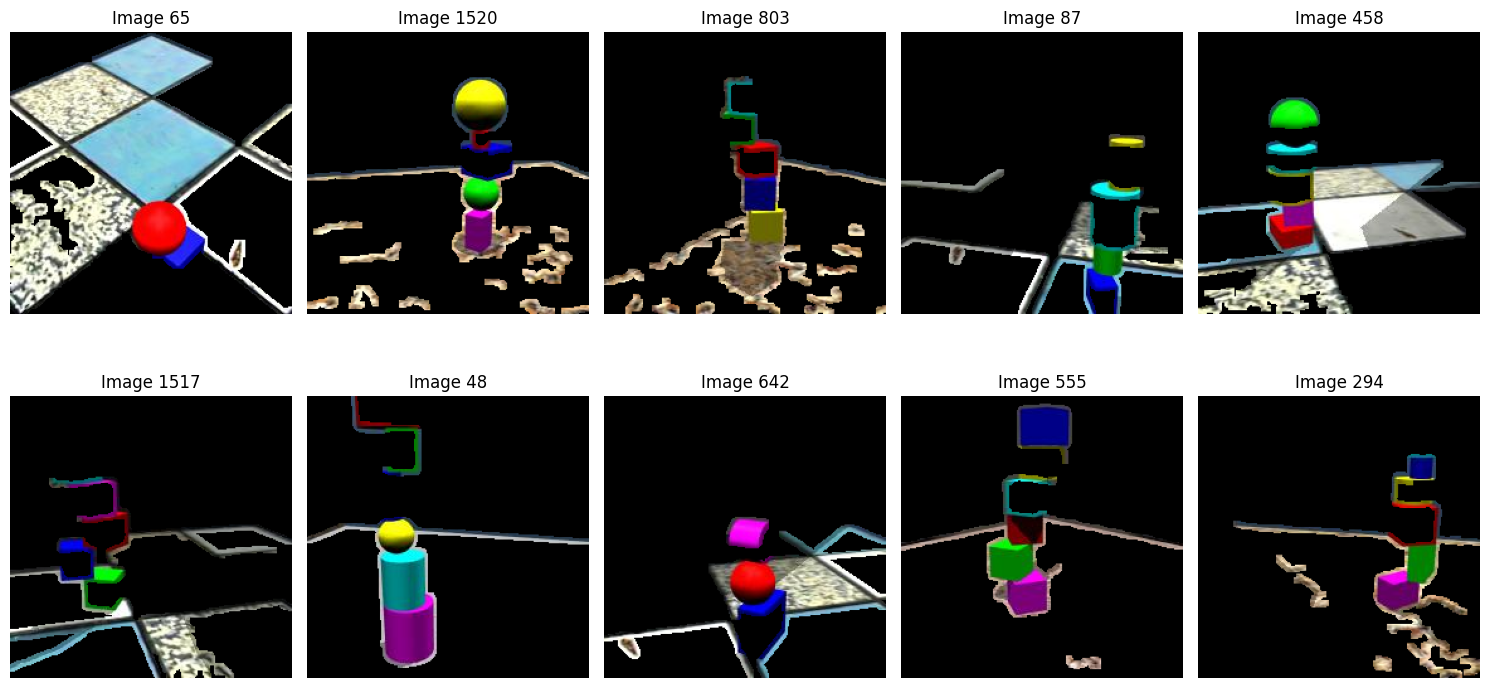

In [ ]:
random_indices = np.random.choice(val_images_segmented.shape[0], size=10, replace=False)

# Set up the plot for displaying images
plt.figure(figsize=(15, 8))

# Loop through the selected indices and display the images
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(val_images_segmented[idx])  # Display the image
    plt.axis('off')  # Hide axis
    plt.title(f'Image {idx}')  # Title with the index of the image

plt.tight_layout()
plt.show()

In [ ]:
def create_resnet_model():
    # Define the image input
    image_input = Input(shape=(224, 224, 3))

    # Build the ResNet50 model as the feature extractor
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model(image_input))  # Apply Global Average Pooling

    # Apply dropout and a final dense layer
    x = Dropout(rate=0.5)(x)
    output = Dense(6, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=image_input, outputs=output)
    return model


In [ ]:
model = create_resnet_model()

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_images,
    train_labels - 1,
    validation_data=(val_images, val_labels - 1),
    epochs=20,
    batch_size=32,
)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 61s 67ms/step - accuracy: 0.2264 - loss: 1.9557 - val_accuracy: 0.2005 - val_loss: 8.9030
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2544 - loss: 1.6202 - val_accuracy: 0.2240 - val_loss: 1.7988
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2524 - loss: 1.5915 - val_accuracy: 0.2422 - val_loss: 1.7001
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2647 - loss: 1.5563 - val_accuracy: 0.2493 - val_loss: 1.8931
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3309 - loss: 1.4914 - val_accuracy: 0.2272 - val_loss: 2.2767
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3997 - loss: 1.3894 - val_accuracy: 0.3457 - val_loss: 1.5277
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4286 - loss: 1.3185 - val_accuracy: 0.4121 - val_loss: 1.7675
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4574 - loss: 1.2736 - val_ac

In [ ]:
test_metadata = pd.read_csv("/content/test.csv")
predictions = []

# Iterate over each ID in the CSV
for img_id in test_metadata['id']:
    # Construct the file path for the image
    img_path = os.path.join("/content/test", f'{img_id}.jpg')

    # Load the image, resize, and preprocess
    test_img = load_img(img_path)
    test_img = img_to_array(test_img)
    #test_img = img_augmentation(test_img, val_test_augmentation)
    #test_img_segmented = segmentation([test_img])

    test_img_segmented = np.expand_dims(test_img, axis=0)  # Add batch dimension if needed

    # Make prediction
    pred = model.predict(test_img_segmented)
    prediction = pred.argmax(axis=1) + 1
    predictions.append(prediction[0])

# Add predictions to the DataFrame and save it to a new CSV
test_metadata['stable_height'] = predictions
test_metadata.to_csv('/content/resnetbaseline.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

In [ ]:
model.save('resnetbaseline.keras')